# Analyze Base Kit Strength

First, we will analyze just kit strength. 
We will create a model that predicts battle results based
only on the sum of the kit strengths of the two teams.
Besides ignoring player skills, this model will also ignore
synergies between kits on the same team, anti-synergies
between kits on opposite teams, game versions, maps,
and game modes.

In [2]:
import logging

logger = logging.getLogger("analyze_base_kit_strength_notebook")
logging.basicConfig(level=logging.INFO)

## Demo battle record creator
Here is a small battle record creator for refining the model

In [3]:
from battle_record import BattleRecord
from typing import Generator


def some_battle_records() -> Generator[BattleRecord, None, None]:
    from read_battle_records import battle_records_from_zip

    return battle_records_from_zip("2024-04-26.zip")

In [10]:
def mar_apr_battle_records() -> Generator[BattleRecord, None, None]:
    """Records for March 27 - April 26, 2024 inclusive"""
    from read_battle_records import battle_records_from_zip

    return battle_records_from_zip("2024-mar-apr-battles.zip")

## Duplicate kit_only_model code

For the sake of not having to reload the libraries constantly, we will duplicate the code
from the `kit_only_model` function in the `battle_record_analysis` module. This will enable
faster iteration.

In [4]:
import pytensor.tensor as tt
from battle_record_analysis import (
    all_kits_used,
    all_observed_kit_variables_and_battle_results,
)
import pymc as pm
from typing import Callable, Iterable


def kit_only_model(
    battle_record_creator: Callable[[], Iterable[BattleRecord]]
) -> pm.Model:
    """
    Create a PyMC3 model for the given battle record creator.

    Here is the formula for each battle record:
    kit_strength = pm.Exp("kit_strength", 1, dims=("kits",))
    both_sides_kit_strengths = concatenate(kit_strength, kit_strength)
    num_and_den_kit_strengths = concatenate(both_sides_kit_strengths, both_sides_kit_strengths)
    num_and_den_observed_kits = concatenate(observed_kit_variables, -abs(observed_kit_variables))
    The basic formula is prob_team_alpha_win for each battle = exp(
        dot(num_and_den_kit_strengths, num_and_den_observed_kits)
    )
    Kit strength's prior distributed as an exponential variable with mean 1

    Args:
        battle_record_creator: A callable that returns an
            iterable of battle records (generally by re-opening the file)

    Returns:
        A PyMC3 model for the given battle record creator.
    """
    kits = sorted(all_kits_used(battle_record_creator()))
    kit_index = {kit: i for i, kit in enumerate(kits)}
    observed_kit_variables, battle_results = (
        all_observed_kit_variables_and_battle_results(
            battle_record_creator(), kit_index
        )
    )
    logger.info(f"Done reading.")
    logger.info(f"Number of kits: {len(kits)}")
    logger.info(f"Shape of observed_kit_variables: {observed_kit_variables.shape}")
    logger.info(f"Shape of battle_results: {battle_results.shape}")

    coords = {"kits": kits}
    with pm.Model(coords=coords) as model:
        observed_kit_data = pm.Data("observed_kit_data", observed_kit_variables)
        battle_results_data = pm.Data("battle_results_data", battle_results)

        kit_strength = tt.reshape(
            pm.Exponential("kit_strength", 1, dims="kits"), (1, -1)
        )
        both_sides_kit_strengths = pm.math.concatenate(
            [kit_strength, kit_strength], axis=1
        )
        single_row_num_and_den_kit_strengths = pm.math.concatenate(
            [both_sides_kit_strengths, both_sides_kit_strengths], axis=1
        )
        logger.info(
            f"Shape of single_row_num_and_den_kit_strengths: {single_row_num_and_den_kit_strengths.shape.eval()}"
        )
        num_and_den_kit_strengths = tt.repeat(
            single_row_num_and_den_kit_strengths,
            observed_kit_data.shape[0],
            axis=0,
        )
        logger.info(
            f"Shape of num_and_den_kit_strengths: {num_and_den_kit_strengths.shape.eval()}"
        )

        num_and_den_observed_kits = pm.math.concatenate(
            [observed_kit_data, -abs(observed_kit_data)], axis=1
        )
        logger.info(
            f"Shape of num_and_den_observed_kits: {num_and_den_observed_kits.shape.eval()}"
        )

        kit_contributions = num_and_den_kit_strengths * num_and_den_observed_kits
        team_alpha_strength = tt.reshape(tt.sum(kit_contributions, axis=1), (-1, 1))
        logger.info(f"Shape of team_alpha_strength: {team_alpha_strength.shape.eval()}")

        prob_team_alpha_win = pm.math.exp(team_alpha_strength)
        pm.Bernoulli(
            "battle_results", prob_team_alpha_win, observed=battle_results_data
        )

    return model

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [12]:
# Vanilla sampler took 18:06 for 1000 samples and 1000 tune
# Nutpie sampler took 16:24 for 1000 samples and 1000 tune
with kit_only_model(some_battle_records) as small_model:
    kit_only_trace = pm.sample(
        1000, tune=1000, cores=4, progressbar=True, nuts_sampler="nutpie"
    )

Tallying weapons used: 0it [00:00, ?it/s]
Reading battles:   0%|          | 0.00/9.98M [00:00<?, ?Bytes/s]
Tallying weapons used: 5872it [00:00, 12304.34it/s]<?, ?Bytes/s, 2024-04-26.csv]
Reading battles: 100%|██████████| 9.98M/9.98M [00:00<00:00, 20.5MBytes/s, 2024-04-26.csv]
Tallying weapons used: 6095it [00:00, 11668.14it/s]
Processing battle records: 0it [00:00, ?it/s]
Reading battles:   0%|          | 0.00/9.98M [00:00<?, ?Bytes/s]
Processing battle records: 5492it [00:00, 11059.87it/s]?Bytes/s, 2024-04-26.csv]
Reading battles: 100%|██████████| 9.98M/9.98M [00:00<00:00, 18.0MBytes/s, 2024-04-26.csv]
Processing battle records: 6095it [00:00, 10919.83it/s]
INFO:analyze_base_weapon_strength_notebook:Done reading.
INFO:analyze_base_weapon_strength_notebook:Number of weapons: 120
INFO:analyze_base_weapon_strength_notebook:Shape of observed_weapon_variables: (6095, 240)
INFO:analyze_base_weapon_strength_notebook:Shape of battle_results: (6095, 1)
INFO:analyze_base_weapon_strength_notebo

In [22]:
import pickle

pickle.dump(kit_only_trace, open("2024-04-26.kit_only_trace.pkl", "wb"))

In [13]:
import arviz as az

az.summary(kit_only_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
weapon_strength[52gal],0.101,0.014,0.074,0.127,0.000,0.000,7729.0,2670.0,1.00
weapon_strength[52gal_deco],0.124,0.028,0.072,0.179,0.000,0.000,7719.0,2206.0,1.00
weapon_strength[96gal],0.041,0.036,0.000,0.106,0.000,0.000,3598.0,1575.0,1.00
weapon_strength[96gal_deco],0.070,0.033,0.008,0.128,0.001,0.000,3022.0,1283.0,1.01
weapon_strength[bamboo14mk1],0.050,0.039,0.000,0.120,0.001,0.000,3932.0,2206.0,1.00
...,...,...,...,...,...,...,...,...,...
weapon_strength_log__[115],-2.845,0.509,-3.794,-2.071,0.009,0.007,4837.0,2087.0,1.00
weapon_strength_log__[116],-2.715,0.760,-3.962,-1.586,0.020,0.016,3054.0,1527.0,1.00
weapon_strength_log__[117],-2.596,0.240,-3.052,-2.169,0.003,0.002,7299.0,2523.0,1.00
weapon_strength_log__[118],-3.035,1.147,-5.108,-1.338,0.027,0.022,3179.0,1733.0,1.00


array([[<Axes: title={'center': 'weapon_strength'}>,
        <Axes: title={'center': 'weapon_strength'}>],
       [<Axes: title={'center': 'weapon_strength_log__'}>,
        <Axes: title={'center': 'weapon_strength_log__'}>]], dtype=object)

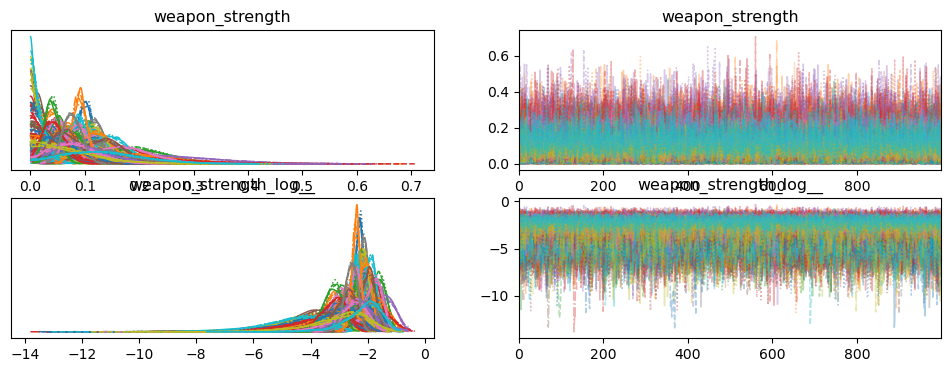

In [14]:
az.plot_trace(kit_only_trace)

In [21]:
with kit_only_model(mar_apr_battle_records) as mar_apr_model:
    mar_apr_kit_only_trace = pm.sample(
        1000, tune=1000, cores=4, progressbar=True, nuts_sampler="nutpie"
    )

Tallying weapons used: 0it [00:00, ?it/s]
Reading battles:   0%|          | 0.00/323M [00:00<?, ?Bytes/s]
Tallying weapons used: 5095it [00:00, 12786.70it/s]?, ?Bytes/s, 2024-03-27.csv]
Reading battles:   3%|▎         | 8.48M/323M [00:00<00:15, 20.9MBytes/s, 2024-03-27.csv]
Tallying weapons used: 8957it [00:00, 12832.10it/s]<00:15, 20.9MBytes/s, 2024-03-28.csv]
Reading battles:   5%|▌         | 16.4M/323M [00:00<00:14, 21.0MBytes/s, 2024-03-28.csv]
Tallying weapons used: 15437it [00:01, 12896.14it/s]00:14, 21.0MBytes/s, 2024-03-29.csv]
Reading battles:   8%|▊         | 26.3M/323M [00:01<00:14, 21.0MBytes/s, 2024-03-29.csv]
Tallying weapons used: 21921it [00:01, 12897.06it/s]00:14, 21.0MBytes/s, 2024-03-30.csv]
Reading battles:  12%|█▏        | 37.3M/323M [00:01<00:13, 21.0MBytes/s, 2024-03-30.csv]
Tallying weapons used: 31722it [00:02, 13955.25it/s]00:13, 21.0MBytes/s, 2024-03-31.csv]
Reading battles:  15%|█▌        | 49.2M/323M [00:02<00:14, 19.2MBytes/s, 2024-03-31.csv]
Tallying weap

KeyboardInterrupt: 

In [ ]:
import pickle

pickle.dump(
    mar_apr_kit_only_trace,
    open("2024-03-25-to-2024-04-26.kit_only_trace.pkl", "wb"),
)

In [16]:
az.summary(mar_apr_kit_only_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
weapon_strength[52gal],0.088,0.003,0.082,0.093,0.000,0.000,4435.0,2967.0,1.0
weapon_strength[52gal_deco],0.105,0.004,0.097,0.112,0.000,0.000,5529.0,2925.0,1.0
weapon_strength[96gal],0.078,0.012,0.054,0.099,0.000,0.000,5270.0,2559.0,1.0
weapon_strength[96gal_deco],0.107,0.007,0.094,0.121,0.000,0.000,5029.0,2716.0,1.0
weapon_strength[bamboo14mk1],0.070,0.010,0.052,0.088,0.000,0.000,4988.0,2676.0,1.0
...,...,...,...,...,...,...,...,...,...
weapon_strength_log__[115],-2.719,0.076,-2.858,-2.581,0.001,0.001,5708.0,3032.0,1.0
weapon_strength_log__[116],-2.501,0.093,-2.671,-2.326,0.001,0.001,5021.0,2875.0,1.0
weapon_strength_log__[117],-2.445,0.040,-2.522,-2.374,0.001,0.000,5551.0,2936.0,1.0
weapon_strength_log__[118],-2.908,0.215,-3.306,-2.518,0.003,0.002,5182.0,2717.0,1.0


array([[<Axes: title={'center': 'weapon_strength'}>,
        <Axes: title={'center': 'weapon_strength'}>],
       [<Axes: title={'center': 'weapon_strength_log__'}>,
        <Axes: title={'center': 'weapon_strength_log__'}>]], dtype=object)

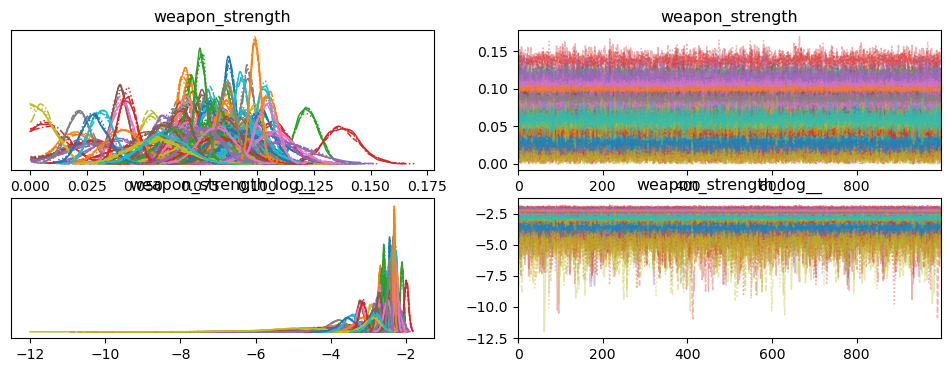

In [17]:
az.plot_trace(mar_apr_kit_only_trace)

In [20]:
az.summary(mar_apr_kit_only_trace, var_names=["kit_strength"], fmt="long")

,weapons,weapon_strength
mean,52gal,0.088
mean,52gal_deco,0.105
mean,96gal,0.078
mean,96gal_deco,0.107
mean,bamboo14mk1,0.070
...,...,...
r_hat,variableroller,1.001
r_hat,variableroller_foil,1.001
r_hat,wakaba,1.000
r_hat,wideroller,1.001
